In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import matplotlib 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import math
import numpy as np
import os

# Quad Params

In [2]:
# calculate gamma*beta
c = 299792458
mec2 = 0.51099895000e6 # eV
Etot = 6e6 #eV
gamma = Etot/mec2
GB = np.sqrt(gamma**2 -1)

p = GB*mec2/1e6  # [MeV/c]

grad = 0.00714  # [T/m]
length =  0.21  # [m]
gap = 0.0254    # [1"] 

# Quad Profile w/Fringe 

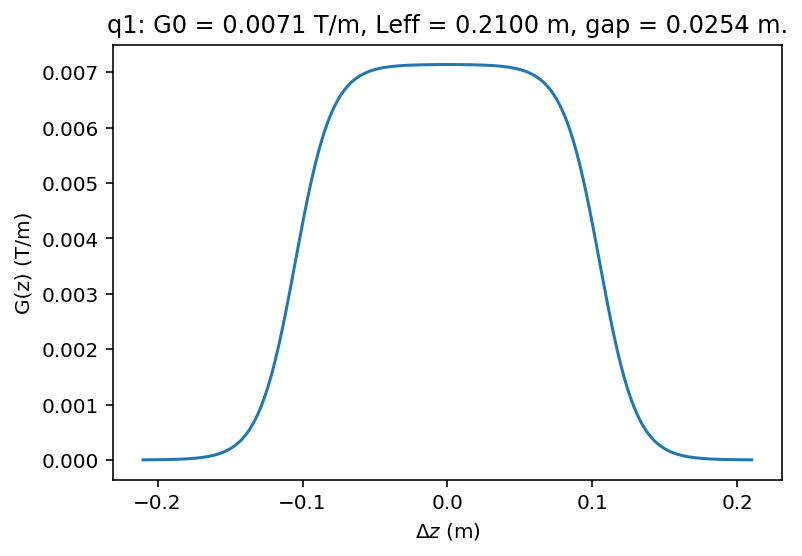

In [3]:
from gpt.element import Lattice
from gpt.bstatic import QuadF

lat = Lattice('quad test')
lat.add(QuadF('q1', grad, length, gap=0.0254), ds=0.25)
lat['q1'].plot(title=True);

# Kick predictions
The kick in the x and y directions for an offset particle can be approximated as $\Delta \theta_x \approx (eG/p)L_{\text{eff}}\cdot\Delta x$ and $\Delta \theta_y \approx -(eG/p)L_{\text{eff}}\cdot\Delta y$

In [4]:
x_off = 1e-3 # 1 mm
y_off = 1e-3 # 1 mm

print('Predicted H-kick:', +lat['q1']._G*c/(p*1e6)*lat['q1'].Leff*x_off)
print('Predicted V-kick:', -lat['q1']._G*c/(p*1e6)*lat['q1'].Leff*y_off)

Predicted H-kick: 7.51913250176069e-05
Predicted V-kick: -7.51913250176069e-05


In [5]:
from gpt import GPT

lat.write_gpt_lines(output_file='gpt.temp.in')

G = GPT(input_file='gpt.temp.in')
G.set_variables({'space_charge':0, 'xacc':12, 'GBacc':12})

particles_x = G.track1(x0=x_off, pz0=p*1e6)

Gx = G.copy()
Gx.run()

particles_y = G.track1(y0=y_off, pz0=p*1e6)
Gy = G.copy()
Gy.run()

print('Computed H-kick:', particles_x.tout[-1]['mean_px']/particles_x.tout[-1]['mean_pz'])
print('Computed V-kick:', particles_y.tout[-1]['mean_py']/particles_y.tout[-1]['mean_pz'])

Computed H-kick: 0.0
Computed V-kick: -7.498133087404194e-05


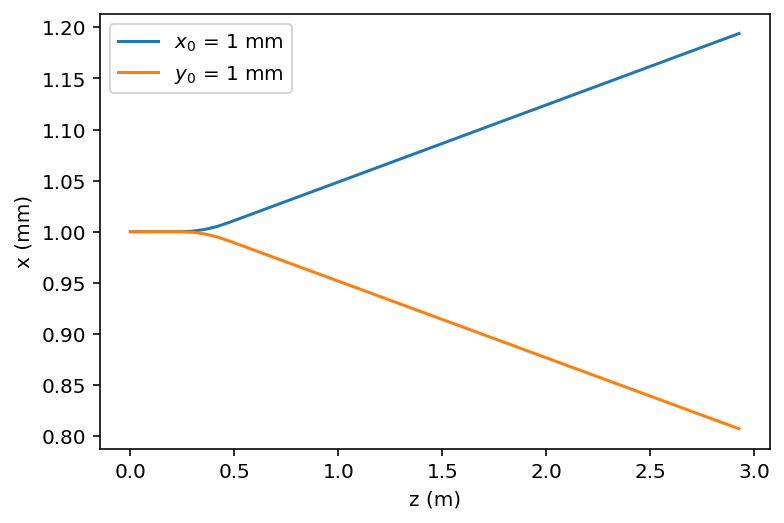

In [6]:
plt.plot(Gx.stat('mean_z'), Gx.stat('mean_x')*1000, Gy.stat('mean_z'), Gy.stat('mean_y')*1000);
plt.xlabel('z (m)');
plt.ylabel('x (mm)');
plt.legend(['$x_0$ = 1 mm', '$y_0$ = 1 mm']);

In [7]:
os.system('rm -rf gpt.temp.in');

# Quad fringe check
Here the consistency of the internal quad fringe field formulas is checked and compared to the results from the quadf custrom GPT element.  First the derivative of the gradient is integrate and compared to the gradient.

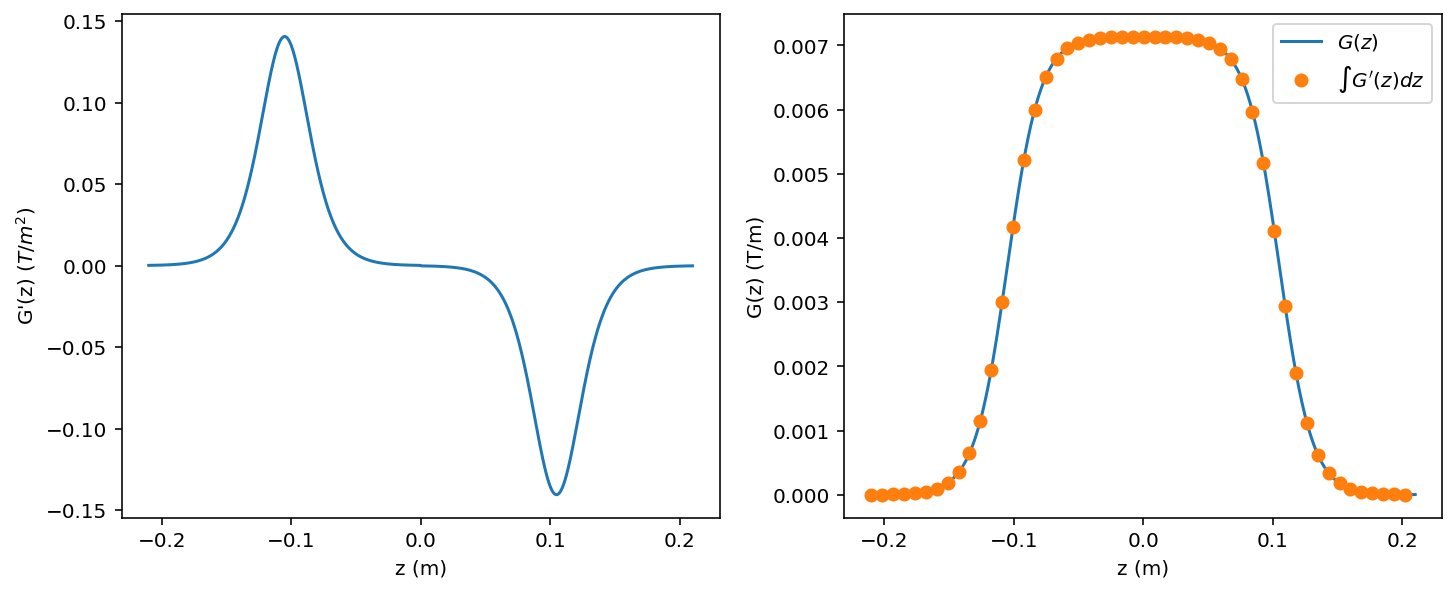

In [8]:
from scipy.integrate import cumtrapz

fig, ax = plt.subplots(1, 2, sharex='col',constrained_layout=True, figsize=[10,4])
lat['q1'].plot_dGdz(ax=ax[0])

grad = cumtrapz(lat['q1'].dGdz, lat['q1'].z, initial=0)
ax[1].plot(lat['q1'].z, lat['q1'].G, lat['q1'].z[::20], grad[::20], 'o');
ax[1].legend(['$G(z)$',"$\int G'(z) dz$"]);
ax[1].set_xlabel('z (m)')
ax[1].set_ylabel('G(z) (T/m)');

Similarly, the second derivative is computed and integrated and compared to the first:

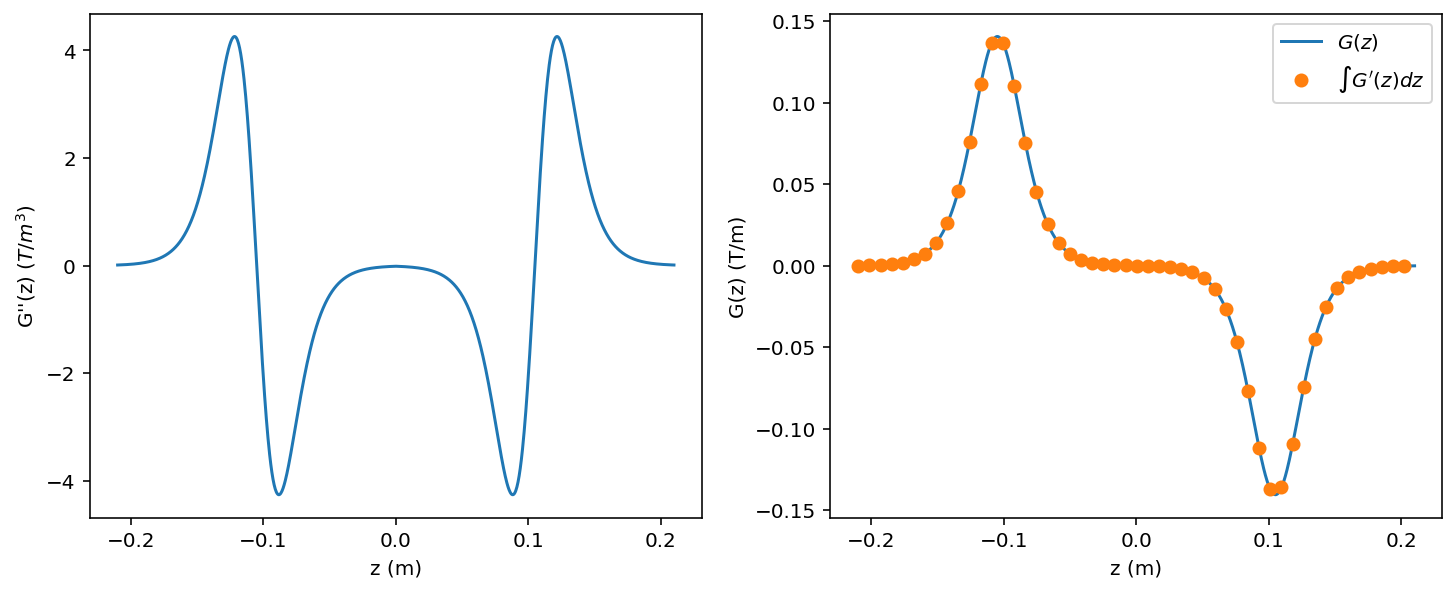

In [9]:
fig, ax = plt.subplots(1, 2, sharex='col',constrained_layout=True, figsize=[10,4])
lat['q1'].plot_d2Gdz2(ax=ax[0])

grad = cumtrapz(lat['q1'].d2Gdz2, lat['q1'].z, initial=0)
ax[1].plot(lat['q1'].z, lat['q1'].dGdz, lat['q1'].z[::20], grad[::20], 'o');
ax[1].legend(['$G(z)$',"$\int G'(z) dz$"]);
ax[1].set_xlabel('z (m)')
ax[1].set_ylabel('G(z) (T/m)');

Finally, these functions are compared to the C code for the custom element in GPT. This is done using the test code ``quadf.cpp``.  This step requires the user to have g++ in their path.

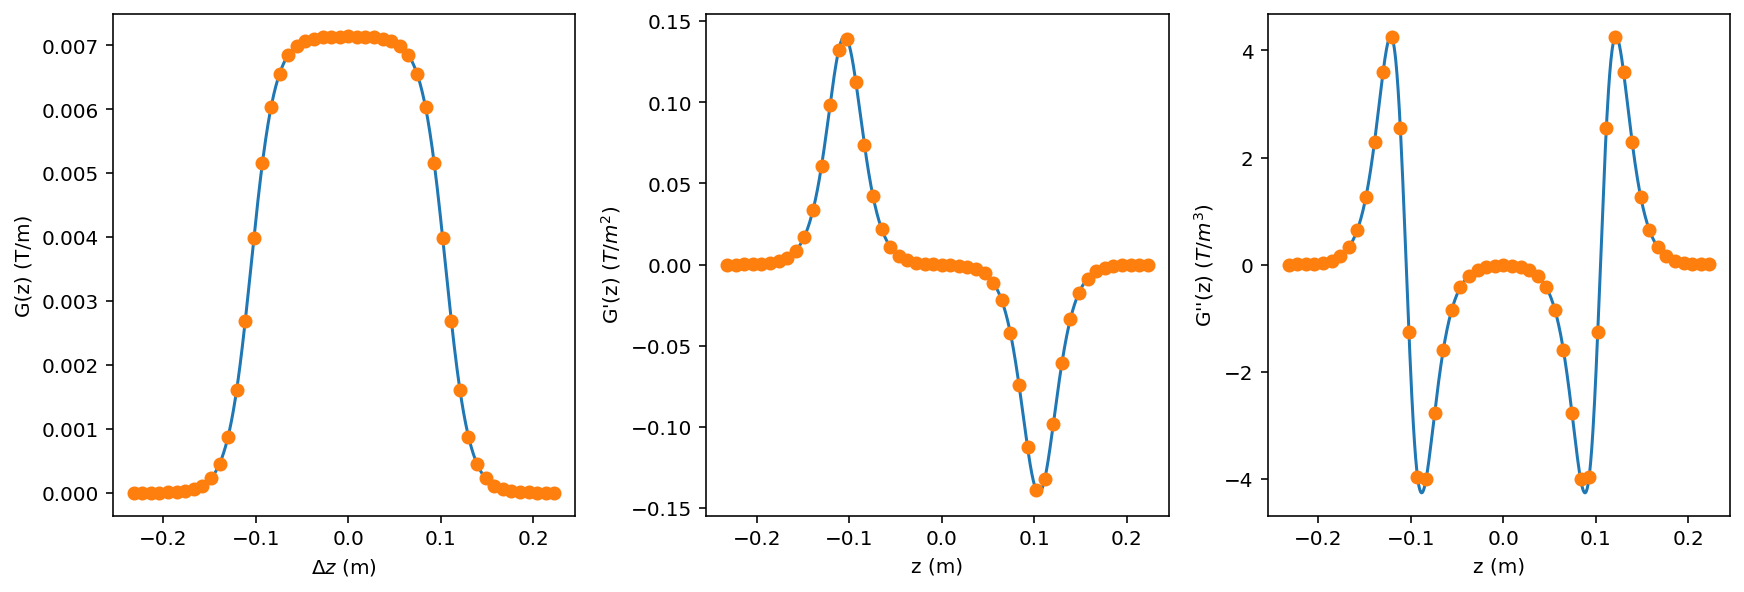

In [10]:
import subprocess
subprocess.run(['g++', '-o', 'quadf', 'quadf.cpp'])
subprocess.run(['./quadf', 'test.txt', str(lat["q1"]._G), str(lat["q1"].L), str(lat["q1"]._b1), str(lat["q1"]._dl)])

fig, ax = plt.subplots(1, 3, sharex='col',constrained_layout=True, figsize=[12,4])

data = np.loadtxt('test.txt', skiprows=1)

lat['q1'].plot(ax=ax[0])
ax[0].plot(data[::10,0], data[::10,1], 'o');

lat['q1'].plot_dGdz(ax=ax[1])
ax[1].plot(data[::10,0], data[::10,2], 'o');

lat['q1'].plot_d2Gdz2(ax=ax[2])
ax[2].plot(data[::10,0], data[::10,3], 'o');

In [11]:
os.system('rm quadf')
os.system('rm test.txt');